# MNIST-Diffusion

### I have defined the three parts for creating a simple diffusion implementation:
- MNIST dataset loader
- A noise scheduler acts as the forward process and allows for the addition of specific amounts of noise to the samples
- Positional encodings encode timestep info to allow the system to have an understanding of how much noise to remove
- U-Net model declaration + training loop creation (for the reverse process)

## Imports

In [30]:
import torch
from torch import nn
import torchvision

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

from config import Config
from unet import UNet

## MNIST dataset loader

### Dataloader blocks

In [2]:
# Dataloader blocks + normalization numbers pulled from: https://nextjournal.com/gkoehler/pytorch-mnist

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: (x*2)-1), # normalizing between -1 and 1
        torchvision.transforms.Resize((128, 128))
    ])), batch_size=16, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: (x*2)-1), # normalizing between -1 and 1
        torchvision.transforms.Resize((128, 128))
    ])),
    batch_size=16, shuffle=True)

### Visualization test

Text(0.5, 1.0, 'Example Image')

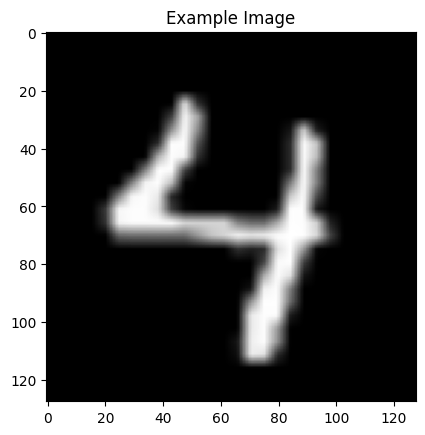

In [3]:
example_img = next(iter(train_loader))[0][0][0]

plt.figure()
plt.imshow(example_img, cmap='gray')
plt.title("Example Image")

## Forward process noise scheduler

<img src="images/forward.png" width="600"/>

### Closed form solution:

<img src="images/closed_forward.png" width="600"/>

### Forward process closed form sample derivation:

<img src="images/forward_equation.png" width="600"/>

Epsilon above is unit normal noise ^

### Posterior variance formula:

<img src="images/posterior_variance.png" width="600"/>

torch.Size([16, 1, 128, 128])


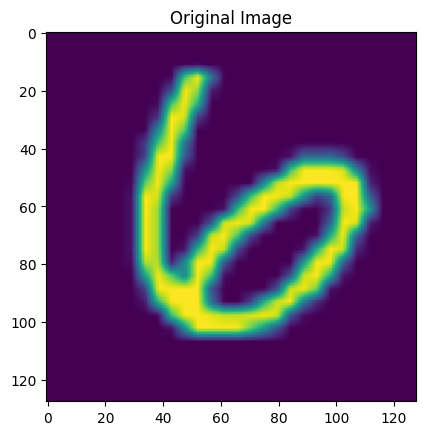

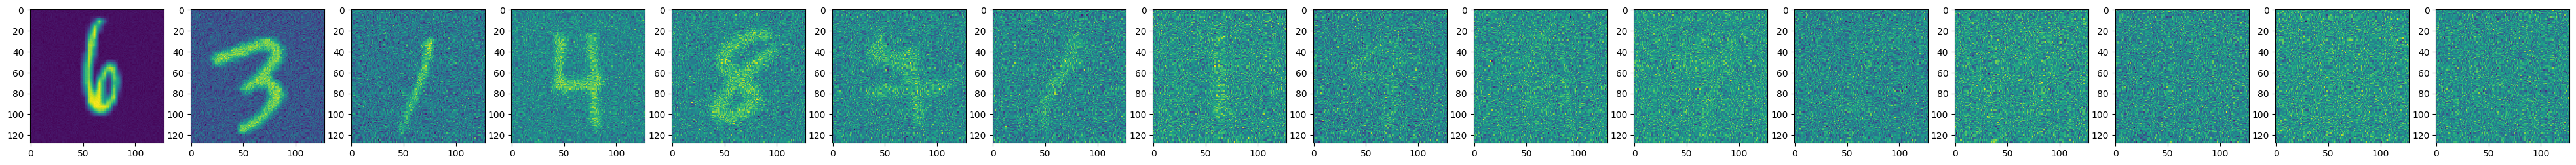

In [13]:
# Referenced when necessary: https://www.youtube.com/watch?v=a4Yfz2FxXiY&ab_channel=DeepFindr

# returns a tensor of beta values spaced in a constant/linear fashion
def create_beta_values(start, end, num_steps):
    return torch.linspace(start, end, num_steps)

# calculating cumulative product of alpha values for closed form solution
def create_cumulative_alphas(betas):
    alpha_vals = 1-betas

    return torch.cumprod(alpha_vals, axis=0)

# returns the respective alpha and 1-alpha values with correct dims for element-wise multiplication
def get_values_from_indexes(values, t_indexs):
    return values.gather(0, t_indexs).reshape(16, 1, 1, 1)

# 200 timesteps
T = 200

# calculating values used in forward pass function
betas = create_beta_values(0.0001, 0.06, T)

cumulative_alphas = create_cumulative_alphas(betas)
sqrt_cumulative_alphas = torch.sqrt(cumulative_alphas)
sqrt_one_minus_cumulative_alphas = torch.sqrt(1 - cumulative_alphas)

cumulative_alphas_prev = torch.cat((torch.tensor([1.0]), cumulative_alphas[:cumulative_alphas.shape[0]-1]), 0)
posterior_variances = betas*(1-cumulative_alphas_prev)/(1-cumulative_alphas)

# to sample specific samples during the forward process, we can use the formula for xt above
def forward_pass(original_images, t):
    # gathering alpha vals for the batch
    true_vals = get_values_from_indexes(sqrt_cumulative_alphas, t)
    true_one_minus_vals = get_values_from_indexes(sqrt_one_minus_cumulative_alphas, t)

    # gathering noise in same shape as original image
    pure_gaussian_noise = torch.randn_like(original_images)
    
    # returning corrupted sample + noise pair
    return (original_images * true_vals) + (pure_gaussian_noise * true_one_minus_vals), pure_gaussian_noise


example_batch = next(iter(train_loader))[0]

print(example_batch.shape)

plt.figure()
plt.imshow(example_batch[15][0])
plt.title("Original Image")

forward_pass_outputs, noise = forward_pass(example_batch, torch.tensor([1, 20, 40, 50, 70, 90, 100, 120, 130, 140, 150, 160, 170, 180, 190, 199]))

fig = plt.figure(figsize=(50, 50))
for i in range(16):
    sub = fig.add_subplot(1, 16, i + 1)
    # cmap colored for easier visualization to verify alpha range
    sub.imshow(forward_pass_outputs[i,0,:,:], interpolation='nearest')


## Reverse process U-Net

### Sinusoidal positional encodings:

<img src="images/positional_encodings.png" width="600"/>

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


Text(0.5, 1.0, 'output Image')

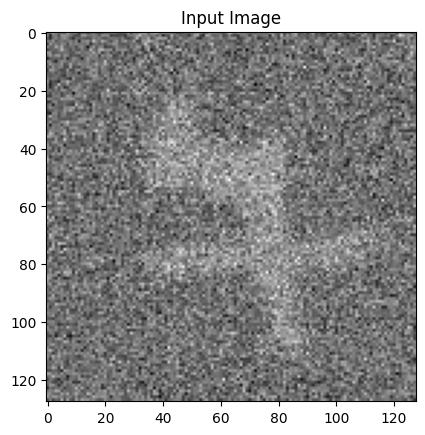

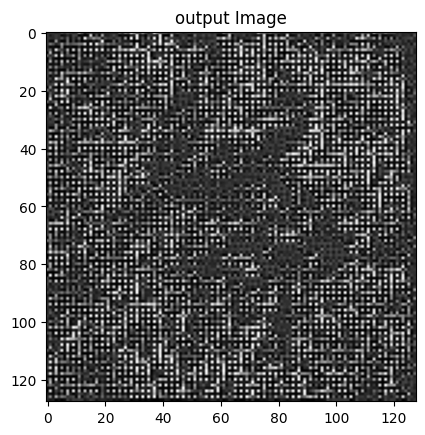

In [14]:
config = Config()
model = UNet(config)

t = torch.tensor([1, 20, 40, 50, 70, 90, 100, 120, 130, 140, 150, 160, 170, 180, 190, 199])
input_test = torch.reshape(example_batch, (16, 1, 128, 128))
input_test, noise = forward_pass(input_test, t)

print(input_test.shape)

output = model(input_test, t)

print(output.shape)

plt.figure()
plt.imshow(input_test.numpy()[5][0], cmap='gray')
plt.title("Input Image")

plt.figure()
plt.imshow(output.detach().numpy()[5][0], cmap='gray')
plt.title("output Image")

## Training utils declarations

In [36]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(model, input_batch, print_loss=False):
    t = torch.randint(1, T, (input_batch.shape[0],))
    input_batch, noise = forward_pass(input_batch, t)

    predicted_noise = model(input_batch, t)

    optimizer.zero_grad()
    loss_vals = loss_func(predicted_noise, noise)
    loss_vals.backward()
    optimizer.step()

    if print_loss:
        print("Loss: " + str(torch.mean(loss_vals).detach().numpy()))

train_step(model, example_batch, True)

Loss: 0.9840138


## Main training loop

In [38]:
model.train()

EPOCHS = 1

for epoch in range(EPOCHS):
    print("EPOCH: " + str(epoch))
    index = 0
    for images, labels in tqdm(train_loader):
        train_step(model, images, (index%50==0))
        index += 1

EPOCH: 0


  0%|          | 1/3750 [00:03<3:17:42,  3.16s/it]

Loss: 0.9521356


  0%|          | 9/3750 [00:29<3:28:34,  3.35s/it]